In [44]:
from os import listdir
import pandas as pd
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# Data source: http://web.mta.info/developers/turnstile.html
datafiles = ['../data/mta_turnstiles/' + x for x in listdir('../data/mta_turnstiles/')]

list_ = []
for file_ in datafiles:
    df = pd.read_csv(file_)
    list_.append(df)
frame = pd.concat(list_)
frame.rename(columns=lambda x: x.strip())

print frame.shape
frame.head(10)

# Slice a limited sample to speed up processing
# frame = frame[:50000]

(777253, 11)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,00:00:00,REGULAR,5672118,1920707
1,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,04:00:00,REGULAR,5672183,1920719
2,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,08:00:00,REGULAR,5672214,1920761
3,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,12:00:00,REGULAR,5672330,1920867
4,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,16:00:00,REGULAR,5672640,1920936
5,A002,R051,02-00-00,59 ST,NQR456,BMT,05/21/2016,20:00:00,REGULAR,5673031,1921000
6,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,00:00:00,REGULAR,5673268,1921052
7,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,04:00:00,REGULAR,5673298,1921061
8,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,08:00:00,REGULAR,5673312,1921080
9,A002,R051,02-00-00,59 ST,NQR456,BMT,05/22/2016,12:00:00,REGULAR,5673379,1921156


In [46]:
# Build dictionary for challenge 1

device_audits = defaultdict(list)

for index, row in frame.iterrows():
    device_audits[tuple(row[0:4])].append(row[4:].tolist())
    
print len(device_audits)


4603


In [47]:
# Build dictionary for challenge 2
# datetime, entries

# Get all audits
device_audits = defaultdict(list)

for index, row in frame.iterrows():
    dstr = row['DATE'] + ' ' + row['TIME']
    dt = datetime.strptime(dstr, '%m/%d/%Y %H:%M:%S')
    en = row[u'ENTRIES']
    device_audits[tuple(row[0:4])].append([dt,en])
    
print len(device_audits)


# Change audits to counts by subtracting values
device_counts = {device: 
                 [(row[i][0], 
                   row[i+1][0] - row[i][0], 
                   row[i+1][1] - row[i][1]) for i in range(len(row)-1)]
                  for device, row in device_audits.iteritems()}

4603


In [48]:
# Look at counts
all_counts = [count for rows in device_counts.values() for (_, _, count) in rows]
all_counts.sort()
print all_counts[-50:]
print all_counts[:1200]

# Look at durations
all_times = [duration.total_seconds() / 60 / 60
             for rows in device_counts.values()
             for _, duration, _ in rows]
print Counter(all_times).most_common(10)

# Remove bad counts
datetime_counts = {turnstile: [(time, count)
                               for (time, _, count) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in device_counts.items()}

# Look at good counts
all_good_counts = [count for rows in datetime_counts.values() for _, count in rows]
print float(len(all_good_counts)) / len(all_counts)

all_good_counts.sort()
print all_good_counts[-5:]
print all_good_counts[:5]

[3033, 3060, 3076, 3096, 3116, 3125, 3168, 3206, 3242, 3320, 3321, 3355, 3367, 3378, 3735, 3768, 4203, 4545, 4695, 5058, 5068, 6078, 6440, 6625, 7370, 7554, 7726, 9003, 10289, 13286, 17168, 17720, 66568, 261543, 393174, 1291975, 1629370, 2402797, 2557082, 2557829, 49514290, 83519145, 116224139, 117416496, 117439681, 317504870, 519992536, 1403818353, 1879007766, 2076115187]
[-1609769922, -1409336682, -519992452, -302009169, -151085187, -117416496, -50370646, -16810693, -14151887, -8092732, -6450530, -6249543, -4313168, -3152690, -2886522, -2754015, -2728372, -2557080, -2556224, -2234351, -2130307, -2082158, -1933256, -1693086, -1629062, -1303776, -1153863, -853125, -801481, -725861, -557859, -530089, -527759, -515629, -393172, -326195, -297769, -281880, -202674, -183043, -174839, -170770, -135440, -105170, -102445, -80768, -78879, -68579, -66457, -46765, -31435, -18659, -17720, -16431, -14866, -11540, -11191, -8197, -3168, -2682, -2393, -2288, -2060, -1993, -1968, -1932, -1902, -1894, -

## Times

Audits are usually taken every 4 hours, but there are also irregular audits in the data.  The DESC variable indicates whether a particular audit was taken regularly or not (http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt).  Samples may be taken irregularly due to planning or troubleshooting activities.

In [49]:
print "Count of audit types"
for s in set(frame["DESC"]):
    ct = frame["DESC"].tolist().count(s)
    print "%s: %d"%(s,ct)

Count of audit types
REGULAR: 774162
RECOVR AUD: 3091


In [50]:
# Challenge 3

# Collapse a list of audits so that all audits on the same are combined into one
def collapse_days(l):
    day_entries = []
    dayset = sorted(set([x[0].date() for x in l]))
    for day in dayset:
        entries = sum([x[1] for x in l if x[0].date() == day])
        day_entries.append((day, entries))
    return day_entries

device_counts_daily = defaultdict(list)
for key,value in datetime_counts.iteritems():
    device_counts_daily[key] = collapse_days(value)
    
print device_counts_daily.iteritems().next()




(('N134', 'R385', '00-00-00', 'ROCKAWAY BLVD'), [(datetime.date(2016, 5, 21), 820), (datetime.date(2016, 5, 22), 640), (datetime.date(2016, 5, 23), 1533), (datetime.date(2016, 5, 24), 1502), (datetime.date(2016, 5, 25), 1593), (datetime.date(2016, 5, 26), 1638), (datetime.date(2016, 5, 27), 1455), (datetime.date(2016, 5, 28), 784), (datetime.date(2016, 5, 29), 660), (datetime.date(2016, 5, 30), 701), (datetime.date(2016, 5, 31), 1381), (datetime.date(2016, 6, 1), 1490), (datetime.date(2016, 6, 2), 1462), (datetime.date(2016, 6, 3), 1522), (datetime.date(2016, 6, 4), 846), (datetime.date(2016, 6, 5), 615), (datetime.date(2016, 6, 6), 1461), (datetime.date(2016, 6, 7), 1643), (datetime.date(2016, 6, 8), 1508), (datetime.date(2016, 6, 9), 1460), (datetime.date(2016, 6, 10), 1452), (datetime.date(2016, 6, 11), 794), (datetime.date(2016, 6, 12), 638), (datetime.date(2016, 6, 13), 1505), (datetime.date(2016, 6, 14), 1544), (datetime.date(2016, 6, 15), 1532), (datetime.date(2016, 6, 16), 1262

('H019', 'R294', '00-06-00', 'MORGAN AV')


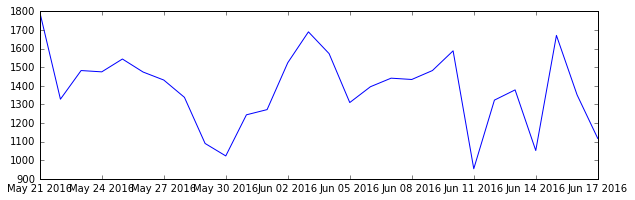

In [53]:
# Challenge 4

%matplotlib inline


turnstiles = device_counts_daily.iteritems()
for i in range(19):
    stile = turnstiles.next()

print stile[0]
ts_data = np.array(stile[1])

dates = ts_data[:,0]
counts = ts_data[:,1]


plt.figure(figsize=(10,3))
plt.plot(dates,counts)